Δl  = 3.001 mm
l   = 2.842 mm
crossing at  a = 10.0 m/s²,  t ≈ 0.0251 s


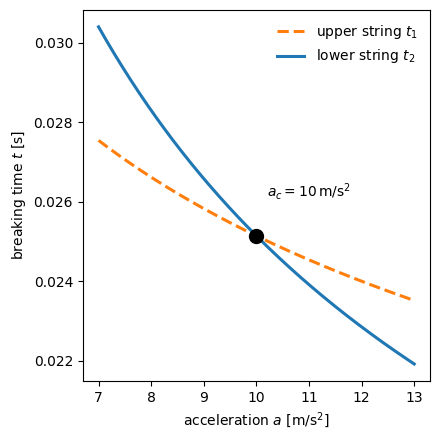

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq


# -------------------------------------------------
# 1. Manuscript constants
# -------------------------------------------------
k_over_m = 1_000.0              #  k/m  [s⁻²]
omega    = np.sqrt(2.0 * k_over_m)
a_cross  = 10.0                 #  target crossover acceleration [m/s²]
t_target = 0.0245               #  desired crossing time  [s]  (≈ 0.024–0.025)

# break extension chosen so t2(a_cross) = t_target exactly
Delta_l  = 0.5 * a_cross * t_target**2      # from lower-string formula

# -------------------------------------------------
# 2. Implicit break–time equations (manuscript Eq. 4)
# -------------------------------------------------
def eq_t1(t, a, l):
    return (Delta_l - l) - a/(2*omega**2) * (np.cos(omega*t) - 1) - (a/4)*t**2

def eq_t2(t, a, l):
    return  Delta_l        + a/(2*omega**2) * (np.cos(omega*t) - 1) - (a/4)*t**2

# -------------------------------------------------
# 3. Solve for the static stretch   l   so t1 = t2 at a = 10
# -------------------------------------------------
def crossing_residual(l):
    t1 = fsolve(eq_t1, t_target, args=(a_cross, l))[0]
    t2 = fsolve(eq_t2, t_target, args=(a_cross, l))[0]
    return t1 - t2

l_static = brentq(crossing_residual, 1e-5, Delta_l - 1e-6)   # search sensible range
t_cross  = fsolve(eq_t1, t_target, args=(a_cross, l_static))[0]

print(f"Δl  = {Delta_l*1000:.3f} mm")
print(f"l   = {l_static*1000:.3f} mm")
print(f"crossing at  a = {a_cross} m/s²,  t ≈ {t_cross:.4f} s")

# -------------------------------------------------
# 4. Compute curves over 7–13 m/s²
# -------------------------------------------------
def solve_t(eq, a):
    """Return smallest positive root of given implicit eq."""
    # try a couple of initial guesses; pick minimal positive root
    roots = []
    for guess in (0.005, 0.02, 0.04):
        try:
            r = fsolve(eq, guess, args=(a, l_static))[0]
            if r > 0:
                roots.append(r)
        except RuntimeError:
            pass
    return min(roots) if roots else np.nan

a_vals = np.linspace(7, 13, 300)
t1_vals = np.array([solve_t(eq_t1, a) for a in a_vals])
t2_vals = np.array([solve_t(eq_t2, a) for a in a_vals])

# -------------------------------------------------
# 5. Plot (dashed = upper string, solid = lower string)
# -------------------------------------------------
plt.figure(figsize=(4.5, 4.5))
plt.plot(a_vals, t1_vals, '--', lw=2.2, color='C1', label='upper string $t_1$')
plt.plot(a_vals, t2_vals,  '-', lw=2.2, color='C0', label='lower string $t_2$')

# highlight crossover
plt.scatter([a_cross], [t_cross], color='k', zorder=5, s =100)
plt.text(a_cross + 0.2, t_cross + 0.001,
         fr'$a_c=10\,\mathrm{{m/s^2}}$',
         fontsize=10)

plt.xlabel(r'acceleration $a$ [m/s$^2$]')
plt.ylabel(r'breaking time $t$ [s]')
#plt.title(r'Breaking Times')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('breaking_times.pdf')
plt.show()


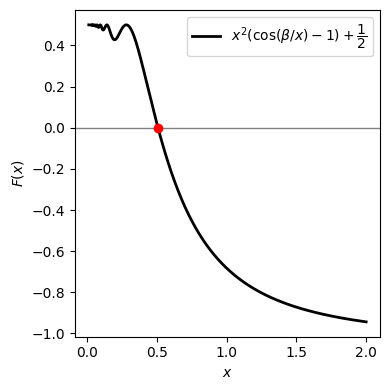

In [2]:
# -----------------------------------------------------
#  Figure 3 – manuscript function and its unique root
# -----------------------------------------------------
β = 1.755

def F(x):
    """Manuscript:  F(x) = x² (cos(β / x) − 1) + ½  """
    return x**2 * (np.cos(β / x) - 1) + 0.5

#  locate the root (≈ 0.507) numerically
root = brentq(F, 0.3, 1.0)     #  bracket where sign changes

# -----------------------------------------------------
#  Plot
# -----------------------------------------------------
x = np.linspace(0.01, 2.0, 800)
y = F(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y, 'k', lw=2, label = r'$x^{2}(\cos(\beta/x)-1)+\dfrac{1}{2}$')
plt.axhline(0, color='gray', lw=1)
plt.scatter(root, 0, color='red', zorder=5)
#plt.annotate(fr'root ≈ {root:.3f}',
#             xy=(root, 0), xytext=(root + 0.25, 0.2),
#             arrowprops=dict(arrowstyle='->', color='red'),
#             fontsize=10)

plt.xlabel('$x$')
plt.ylabel('$F(x)$')
#plt.title(r'$F(x)=x^{2}(\cos(\beta/x)-1)+\dfrac{1}{2}$  ' rf'with $\beta={β}$',fontsize=11)
plt.legend()
plt.tight_layout()
plt.savefig('3.pdf')
plt.show()


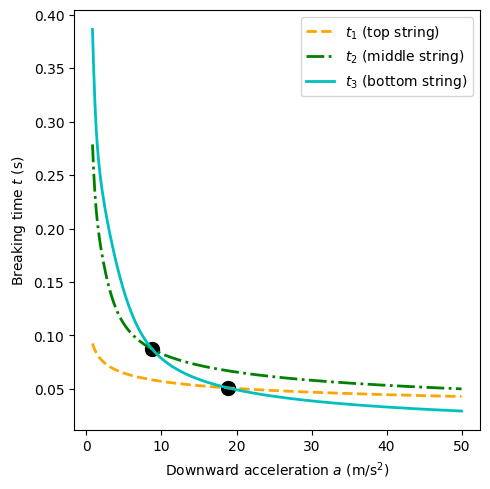

In [4]:
# parameters
k_over_m = 1_000.0
g = 9.81
delta_l = 0.02               # 20 mm
omega1 = math.sqrt(k_over_m)
omega2 = math.sqrt(3*k_over_m)
l1 = 2*g/k_over_m
l2 = g/k_over_m

# root finding
def root(func, t_upper=10.0, dt=1e-3, max_iter=12):
    t_max = t_upper
    for _ in range(max_iter):
        t = np.arange(dt, t_max+dt, dt)
        f = func(t)
        s = np.sign(f)
        idx = np.where(s[:-1]*s[1:] <= 0)[0]
        if idx.size:
            left, right = t[idx[0]], t[idx[0]+1]
            for _ in range(40):
                mid = 0.5*(left+right)
                if func(np.array([left]))*func(np.array([mid])) <= 0:
                    right = mid
                else:
                    left = mid
            return 0.5*(left+right)
        t_max *= 2
    return np.nan

def breaking_times(a):
    f1 = lambda t: (a/(2*omega1**2))*np.cos(omega1*t) - (a/(6*omega2**2))*np.cos(omega2*t) + (a/6)*t**2 - (4*a)/(9*omega1**2) - (delta_l - l1)
    f2 = lambda t: (a/(3*omega2**2))*np.cos(omega2*t) + (a/6)*t**2 - a/(9*omega1**2) - (delta_l - l2)
    f3 = lambda t: (a/6)*t**2 - (a/(2*omega1**2))*np.cos(omega1*t) - (a/(6*omega2**2))*np.cos(omega2*t) + (5*a)/(9*omega1**2) - delta_l
    return root(f1), root(f2), root(f3)

# compute values
a_vals = np.linspace(0.8, 50, 300)
t1_vals, t2_vals, t3_vals = [], [], []
for a in a_vals:
    t1, t2, t3 = breaking_times(a)
    t1_vals.append(t1)
    t2_vals.append(t2)
    t3_vals.append(t3)

# find intersections
def find_intersection(x, y1, y2):
    y1, y2 = np.array(y1), np.array(y2)
    s = np.sign(y1 - y2)
    idx = np.where(s[:-1] * s[1:] < 0)[0]
    pts = []
    for i in idx:
        a_i = (x[i] + x[i+1]) / 2
        t_i = (y1[i] + y1[i+1]) / 2
        pts.append((a_i, t_i))
    return pts

int12 = find_intersection(a_vals, t1_vals, t2_vals)
int23 = find_intersection(a_vals, t2_vals, t3_vals)
int13 = find_intersection(a_vals, t1_vals, t3_vals)

# pick first intersections if present
pts = {
    't1=t2': int12[0] if int12 else (None, None),
    't2=t3': int23[0] if int23 else (None, None),
    't1=t3': int13[0] if int13 else (None, None)
}

# plot
plt.figure(figsize=(5, 5))
plt.plot(a_vals, t1_vals, '--', linewidth=2, label='$t_1$ (top string)', color = 'orange')
plt.plot(a_vals, t2_vals, '-.', linewidth=2, label='$t_2$ (middle string)', color = 'green')
plt.plot(a_vals, t3_vals, '-', linewidth=2, label='$t_3$ (bottom string)', color = 'c')
# annotate intersections
for label, (a_i, t_i) in pts.items():
    if a_i is not None:
        plt.scatter([a_i], [t_i], marker='o', s=100, c='k')

plt.xlabel('Downward acceleration $a$ (m/s$^2$)')
plt.ylabel('Breaking time $t$ (s)')
#plt.title('Breaking Time vs. Acceleration with Intersection Points')
plt.legend()
plt.tight_layout()
plt.savefig('4.pdf')
plt.show()
